# AI's Evolutionary Path: What the Future Holds for Professions
### Part 3: NLP Name Entitiy Recognition (NER) & Customized Sentiment Analysis
### Author: Hyojun Kim

## Data Preparation

In [1]:
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]


In [2]:
import os
import time
import re

import pandas as pd
import numpy as np
from pandarallel import pandarallel
from multiprocessing import Pool, cpu_count
from transformers import pipeline
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import seaborn as sns
from itertools import compress
import pickle 


import gensim
from gensim import corpora, models
from gensim.models import LdaMulticore, Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import spacy
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import torch
import gc


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
from nltk.corpus import stopwords

In [3]:
import warnings

warnings.simplefilter('once')

import multiprocessing
from multiprocessing import Pool, cpu_count

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1
print(f"Using {workers} workers")

#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
Using 7 workers
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Copy files to local FS from GCP bucket

In [4]:
path_prep = '/Users/hyojun/Desktop/data/NLP/prep'
path_lda = '/Users/hyojun/Desktop/data/NLP/lda'
path_sentiment = '/Users/hyojun/Desktop/data/NLP/sentiment'
path_ner = '/Users/hyojun/Desktop/data/NLP/ner'

if not os.path.isdir(path_prep): os.mkdir(path_prep)
if not os.path.isdir(path_lda): os.mkdir(path_lda)
if not os.path.isdir(path_sentiment): os.mkdir(path_sentiment)
if not os.path.isdir(path_ner): os.mkdir(path_ner)

In [5]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [6]:
import spacy 
from spacy import displacy
spacy.prefer_gpu()
spacy.require_gpu()

print(spacy.__version__)

nlp = spacy.load('en_core_web_sm')

if spacy.require_gpu():
    print("GPU is being used")
else:
    print("GPU is not being used")


3.6.0
GPU is being used


## Read The Previous Data of Preprocessed Texts from the Part 1 and 2

In [7]:
# Load texts
ai_integration = pd.read_pickle(os.path.join(path_sentiment, 'ai_integration.pkl'))
ai_impact = pd.read_pickle(os.path.join(path_sentiment, 'ai_impact.pkl'))
ai_technology = pd.read_pickle(os.path.join(path_sentiment, 'ai_technology.pkl'))

# Load sentiments
ai_integration_sentiment = pd.read_pickle(os.path.join(path_sentiment, 'ai_integration_sentiment.pkl'))
ai_impact_sentiment = pd.read_pickle(os.path.join(path_sentiment, 'ai_impact_sentiment.pkl'))
ai_technology_sentiment = pd.read_pickle(os.path.join(path_sentiment, 'ai_technology_sentiment.pkl'))

## Identify Top Candidates for AI Integration

In [8]:
def plot_sentiment_trends(df, topic):
    # Calculate sentiment proportions
    df['positive_proportion'] = df['rolling_positive'] / (df['rolling_positive'] + df['rolling_negative'])
    df['negative_proportion'] = df['rolling_negative'] / (df['rolling_positive'] + df['rolling_negative'])
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot positive sentiment proportion on the left subplot
    axs[0].plot(df['date'], df['positive_proportion'], label='Positive Sentiment Proportion', color='green')
    
    # Plot negative sentiment proportion on the right subplot
    axs[1].plot(df['date'], df['negative_proportion'], label='Negative Sentiment Proportion', color='red')
    
    # Set titles and axis labels for both subplots
    axs[0].set_title(f'Positive Sentiment Trends for {topic}')
    axs[1].set_title(f'Negative Sentiment Trends for {topic}')
    axs[1].set_xlabel('Date')
    axs[0].set_ylabel('Sentiment Proportion (0-1)')
    
    # Set grid and tick parameters for both subplots
    axs[0].grid(True)
    axs[1].grid(True)
    axs[1].tick_params(axis='x', rotation=45)
    
    # Set y-axis limits for both subplots
    axs[0].set_ylim(0, 1)
    axs[1].set_ylim(0, 1)
    
    # Add legends to both subplots
    axs[0].legend(loc='upper left')
    axs[1].legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

### Plot Overall Sentiment Trends for AI Integration

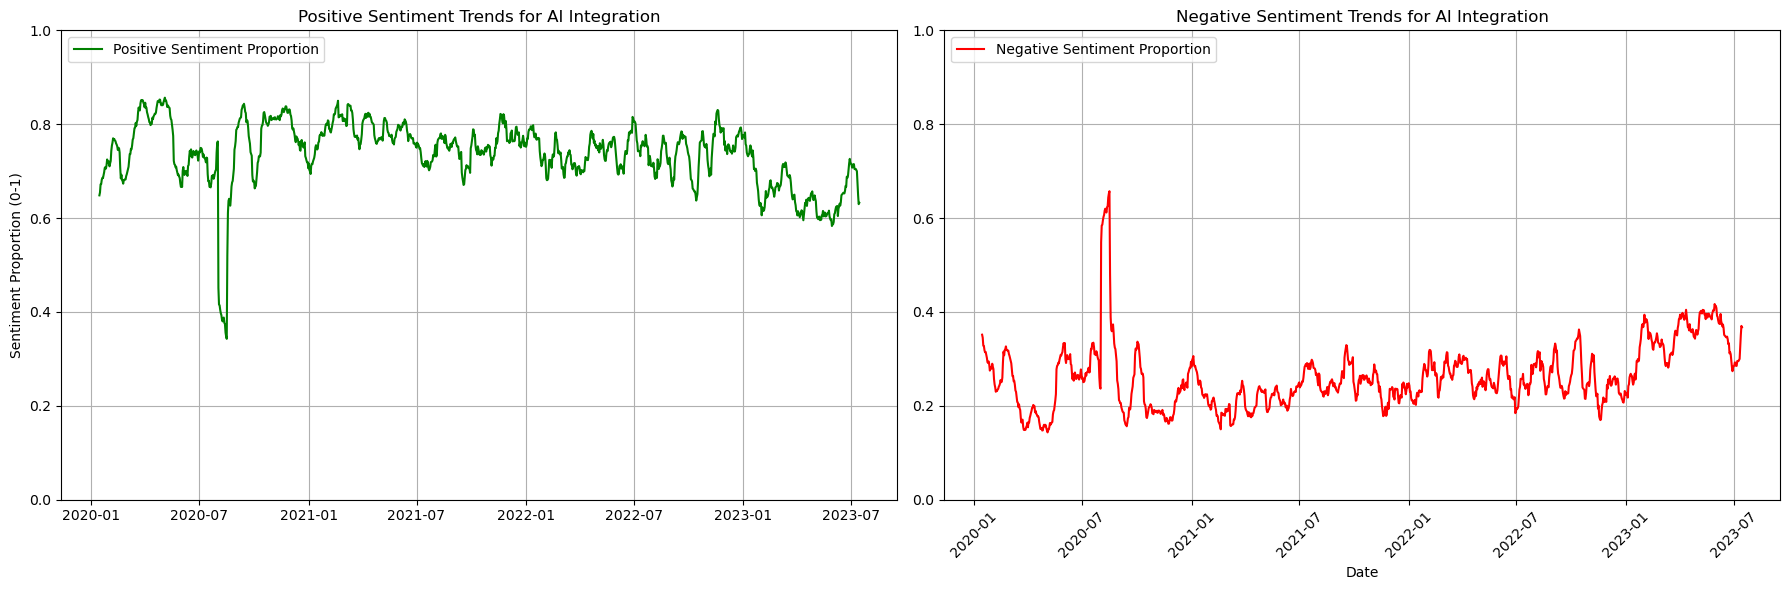

In [9]:
# Plot sentiment trends for 'ai_integration'
plot_sentiment_trends(ai_integration_sentiment, 'AI Integration')


### Perform NER w/ SpaCy for AI Integration

In [10]:
%%time

nlp = spacy.load('en_core_web_sm')

def process_chunk(chunk_texts):
    org_entities = defaultdict(int)
    person_entities = defaultdict(int)
    loc_entities = defaultdict(int)
    
    org_context = defaultdict(list)  # Use lists instead of sets for context
    person_context = defaultdict(list)
    loc_context = defaultdict(list)
    
    for text in tqdm(chunk_texts, desc="Processing chunk"):
        doc = nlp(text)
        for sent in doc.sents:
            for ent in sent.ents:
                if ent.label_ == 'ORG':
                    org_entities[ent.text] += 1
                    org_context[ent.text].append(sent.text)
                elif ent.label_ == 'PERSON':
                    person_entities[ent.text] += 1
                    person_context[ent.text].append(sent.text)
                elif ent.label_ == 'GPE':
                    loc_entities[ent.text] += 1
                    loc_context[ent.text].append(sent.text)
                    
    return org_entities, person_entities, loc_entities, org_context, person_context, loc_context


CPU times: user 305 ms, sys: 27.6 ms, total: 333 ms
Wall time: 382 ms


## ====== NLP Techniques to Identify ORG, PEOPLE, and GPE (LOC) ======

In [11]:
def get_top_candidates_context(texts):
    org_entities = defaultdict(int)
    person_entities = defaultdict(int)
    loc_entities = defaultdict(int)
    
    # Store context of entities using sets for efficient insertion and lookup
    org_context = defaultdict(set)
    person_context = defaultdict(set)
    loc_context = defaultdict(set)
    
    for doc in tqdm(nlp.pipe(texts), total=len(texts)):
        for sent in doc.sents:
            for ent in sent.ents:
                if ent.label_ == 'ORG':
                    org_entities[ent.text] += 1
                    org_context[ent.text].add(sent.text)
                elif ent.label_ == 'PERSON':
                    person_entities[ent.text] += 1
                    person_context[ent.text].add(sent.text)
                elif ent.label_ == 'GPE':
                    loc_entities[ent.text] += 1
                    loc_context[ent.text].add(sent.text)
                    
    # Convert sets back to lists for more familiar usage and compatibility with serialization like pickling
    org_context = {key: list(value) for key, value in org_context.items()}
    person_context = {key: list(value) for key, value in person_context.items()}
    loc_context = {key: list(value) for key, value in loc_context.items()}
                
    return org_entities, person_entities, loc_entities, org_context, person_context, loc_context

### Split "ai_integration" into 1 and 2 since the data is large.

In [12]:
# # Split the data into two parts
# half_length = len(ai_integration['text_clean']) // 2
# first_half = ai_integration['text_clean'][:half_length]
# second_half = ai_integration['text_clean'][half_length:]

# # Process the first half of the data
# integration_org_entities_1, integration_person_entities_1, integration_loc_entities_1, integration_org_context_1, integration_person_context_1, integration_loc_context_1 = get_top_candidates_context(first_half)

# # Process the second half of the data
# integration_org_entities_2, integration_person_entities_2, integration_loc_entities_2, integration_org_context_2, integration_person_context_2, integration_loc_context_2 = get_top_candidates_context(second_half)

### Combine 1 and 2 ai_integrations into 1: 

In [13]:
# # Combine the results from processing the two halves of the data
# integration_org_entities = {**integration_org_entities_1}
# for key, value in integration_org_entities_2.items():
#     if key in integration_org_entities:
#         integration_org_entities[key] += value
#     else:
#         integration_org_entities[key] = value

# integration_person_entities = {**integration_person_entities_1}
# for key, value in integration_person_entities_2.items():
#     if key in integration_person_entities:
#         integration_person_entities[key] += value
#     else:
#         integration_person_entities[key] = value

# integration_loc_entities = {**integration_loc_entities_1}
# for key, value in integration_loc_entities_2.items():
#     if key in integration_loc_entities:
#         integration_loc_entities[key] += value
#     else:
#         integration_loc_entities[key] = value

# integration_org_context = {**integration_org_context_1}
# for key, value in integration_org_context_2.items():
#     if key in integration_org_context:
#         integration_org_context[key].extend(value)
#     else:
#         integration_org_context[key] = value

# integration_person_context = {**integration_person_context_1}
# for key, value in integration_person_context_2.items():
#     if key in integration_person_context:
#         integration_person_context[key].extend(value)
#     else:
#         integration_person_context[key] = value

# integration_loc_context = {**integration_loc_context_1}
# for key, value in integration_loc_context_2.items():
#     if key in integration_loc_context:
#         integration_loc_context[key].extend(value)
#     else:
#         integration_loc_context[key] = value

In [14]:
# with open(os.path.join(path_ner, f'integration_org_entities.pkl'), 'wb') as f:
#     pickle.dump(integration_org_entities, f)
# with open(os.path.join(path_ner, f'integration_person_entities.pkl'), 'wb') as f:
#     pickle.dump(integration_person_entities, f)
# with open(os.path.join(path_ner, f'integration_loc_entities.pkl'), 'wb') as f:
#     pickle.dump(integration_loc_entities, f)
# with open(os.path.join(path_ner, f'integration_org_context.pkl'), 'wb') as f:
#     pickle.dump(integration_org_context, f)
# with open(os.path.join(path_ner, f'integration_person_context.pkl'), 'wb') as f:
#     pickle.dump(integration_person_context, f)
# with open(os.path.join(path_ner, f'integration_loc_context.pkl'), 'wb') as f:
#     pickle.dump(integration_loc_context, f)

### Checkpoint

In [15]:
# Load data
with open(os.path.join(path_ner, 'integration_org_entities.pkl'), 'rb') as f:
    integration_org_entities = pickle.load(f)
with open(os.path.join(path_ner, 'integration_person_entities.pkl'), 'rb') as f:
    integration_person_entities = pickle.load(f)
with open(os.path.join(path_ner, 'integration_loc_entities.pkl'), 'rb') as f:
    integration_loc_entities = pickle.load(f)
with open(os.path.join(path_ner, 'integration_org_context.pkl'), 'rb') as f:
    integration_org_context = pickle.load(f)
with open(os.path.join(path_ner, 'integration_person_context.pkl'), 'rb') as f:
    integration_person_context = pickle.load(f)
with open(os.path.join(path_ner, 'integration_loc_context.pkl'), 'rb') as f:
    integration_loc_context = pickle.load(f)

### Top Candidates for AI Integration

In [16]:
# Replace specific string names before sorting and printing
def replace_entity_names(entity_dict, original_name, new_name):
    if original_name in entity_dict:
        entity_dict[new_name] = entity_dict.pop(original_name)
    return entity_dict

# Replace names
integration_org_entities = replace_entity_names(integration_org_entities, "media group inc station gray television inc", "media group inc")

# Sort entities by frequency and get top 10
sorted_orgs = sorted(integration_org_entities.items(), key=lambda x: x[1], reverse=True)
sorted_persons = sorted(integration_person_entities.items(), key=lambda x: x[1], reverse=True)
sorted_locs = sorted(integration_loc_entities.items(), key=lambda x: x[1], reverse=True)

In [17]:
# Print top candidates
print("Top Organizations for AI Integration:")
for org, freq in sorted_orgs[:10]:
    print(f"{org}: {freq} mentions")


Top Organizations for AI Integration:
microsoft: 79891 mentions
google: 62661 mentions
ibm: 40362 mentions
fcc: 36726 mentions
media group inc: 35617 mentions
gpt: 28720 mentions
intel: 18235 mentions
fda: 16192 mentions
npr: 14167 mentions
congress: 11652 mentions


In [18]:

print("\nTop Persons for AI Integration:")
for person, freq in sorted_persons[:10]:
    print(f"{person}: {freq} mentions")



Top Persons for AI Integration:
sam altman: 7098 mentions
van susterencircle: 4170 mentions
joe biden: 3914 mentions
norge polska: 3820 mentions
pichai: 3522 mentions
max: 2868 mentions
matt obrien: 2719 mentions
mike: 2633 mentions
zambia zimbabwe: 2576 mentions
donald trump: 2547 mentions


In [19]:

print("\nTop Locations for AI Integration:")
for loc, freq in sorted_locs[:10]:
    print(f"{loc}: {freq} mentions")


Top Locations for AI Integration:
us: 95200 mentions
india: 74045 mentions
china: 55188 mentions
japan: 30361 mentions
france: 29200 mentions
new york: 28125 mentions
russia: 25447 mentions
washington: 24683 mentions
california: 24617 mentions
texas: 24209 mentions


### Plot Barchart for Top Candidates for AI Integration

In [20]:
def plot_single_entity_chart(entities, title, color):
    """
    Function to plot single entity chart.
    
    Args:
    - entities (list): List of tuple with entity and its count.
    - title (str): Title for the bar chart.
    - color (str): Color for the bars.
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axis
    
    # Extract names and their frequencies
    names = [entity[0] for entity in entities]
    frequencies = [entity[1] for entity in entities]
    
    # Plot
    bars = ax.barh(names, frequencies, color=color)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width - 0.079 * max(frequencies), bar.get_y() + bar.get_height()/2, f'{width}', va='center', color='black', fontweight='bold', fontsize=10)

    ax.set_xlabel('Frequency', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.invert_yaxis()  # Invert y-axis to have the entity with the highest frequency at the top
    plt.tight_layout()
    
    plt.show() 

# Colors for each plot 
colors = ['#87CEFA']

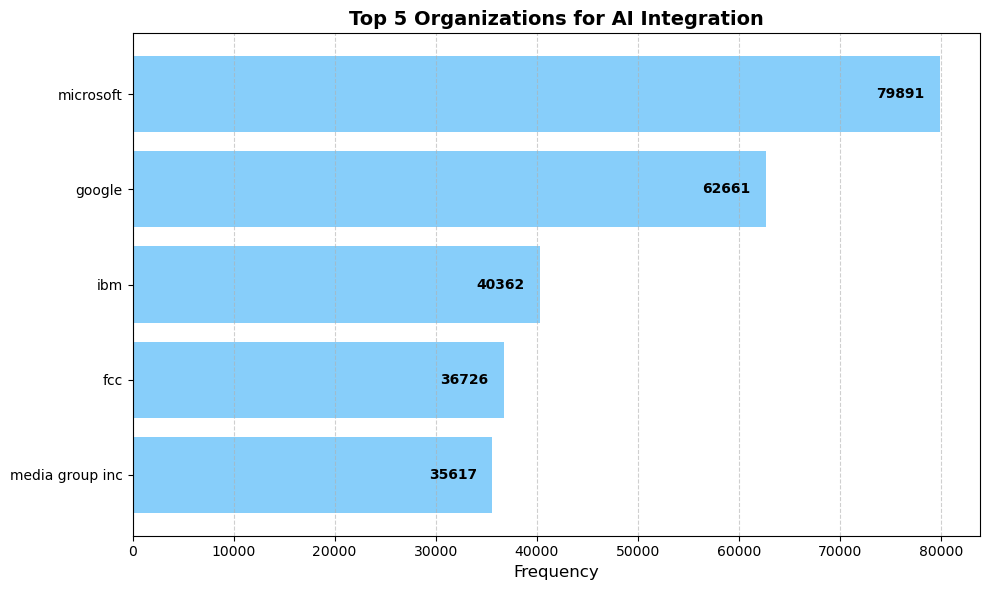

In [21]:
# Plot Organizations
plot_single_entity_chart(sorted_orgs[:5], "Top 5 Organizations for AI Integration", colors[0])


In [22]:
def plot_single_entity_chart(entities, title, color):
    """
    Function to plot single entity chart.
    
    Args:
    - entities (list): List of tuple with entity and its count.
    - title (str): Title for the bar chart.
    - color (str): Color for the bars.
    """
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axis
    
    # Extract names and their frequencies
    names = [entity[0] for entity in entities]
    frequencies = [entity[1] for entity in entities]
    
    # Plot
    bars = ax.barh(names, frequencies, color=color)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width - 0.057 * max(frequencies), bar.get_y() + bar.get_height()/2, f'{width}', va='center', color='black', fontweight='bold', fontsize=10)

    ax.set_xlabel('Frequency', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.invert_yaxis()  # Invert y-axis to have the entity with the highest frequency at the top
    plt.tight_layout()
    
    plt.show()  

# Colors for each plot 
colors = ['#FFB6C1', '#98FB98']

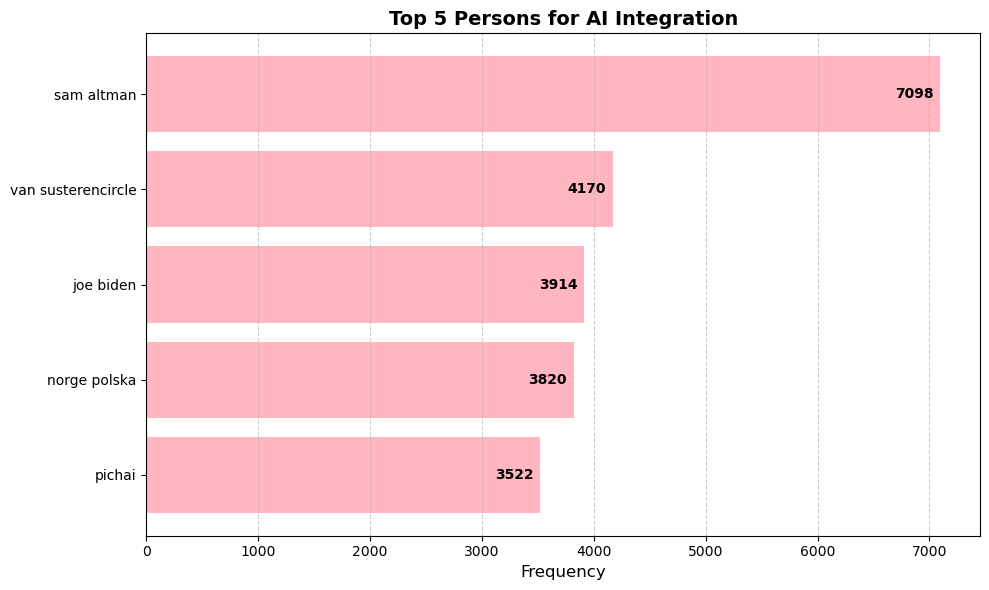

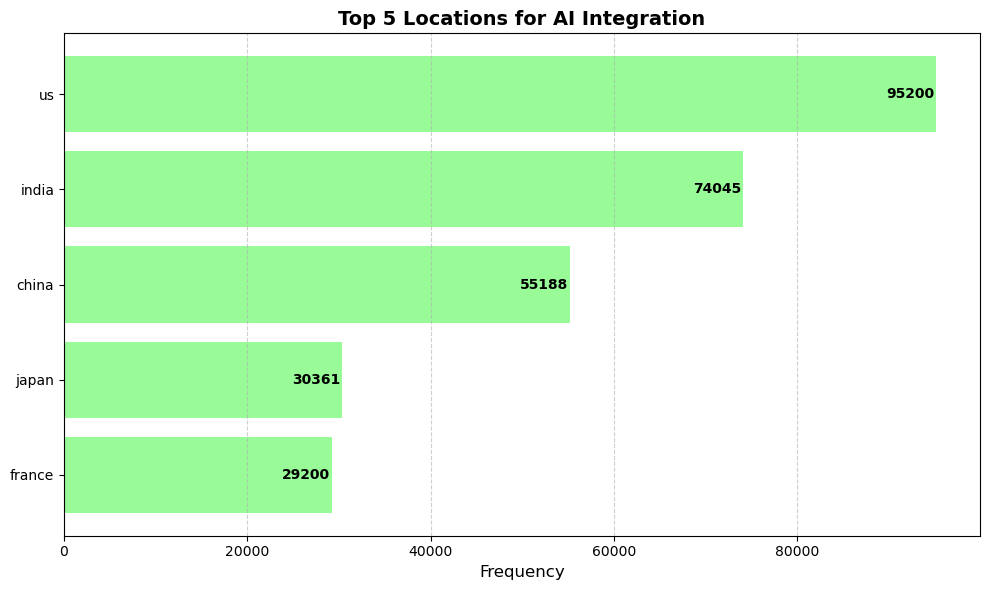

In [23]:
# Plot Persons
plot_single_entity_chart(sorted_persons[:5], "Top 5 Persons for AI Integration", colors[0])

# Plot Locations
plot_single_entity_chart(sorted_locs[:5], "Top 5 Locations for AI Integration", colors[1])


### Visualize the Top Candidates for AI Integration
Covers:

    - Sentiment Analysis - Rolling Mean
    - Sentiment Analysis - Proportion

In [24]:
# Extract the top 5 organizations, persons, and locations
top_5_orgs = [org for org, freq in sorted_orgs[:5]]
top_5_persons = [person for person, freq in sorted_persons[:5]]
top_5_locs = [loc for loc, freq in sorted_locs[:5]]


# Filter ai_integration based on top organizations in text
org_filtered = ai_integration[ai_integration['text_clean'].str.contains('|'.join(top_5_orgs), case=False, na=False)]
per_filtered = ai_integration[ai_integration['text_clean'].str.contains('|'.join(top_5_persons), case=False, na=False)]
locs_filtered = ai_integration[ai_integration['text_clean'].str.contains('|'.join(top_5_locs), case=False, na=False)]


# Merge sentiment data from ai_integration_sentiment based on date
merged_org = pd.merge(org_filtered, ai_integration_sentiment, on='date', how='left')
merged_per = pd.merge(per_filtered, ai_integration_sentiment, on='date', how='left')
merged_locs = pd.merge(locs_filtered, ai_integration_sentiment, on='date', how='left')

### Sentiment Analysis - Rolling Mean

In [25]:
def plot_sentiments_rolling_mean(entity_list, merged_sentiments_df, title):
    fig, ax = plt.subplots(figsize=(18, 6))
    
    pos_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
    neg_colors = ['#1b9e77', '#d95f02', '#7570b3', '#d7301f', '#66a61e']
    positive_legend_handles = []
    negative_legend_handles = []
    
    for idx, entity in enumerate(entity_list):
        entity_df = merged_sentiments_df[merged_sentiments_df['text_clean'].str.contains(entity, case=False, na=False)]
        entity_df = entity_df.sort_values(by='date')
        
        # Plotting the rolling means
        positive_line, = ax.plot(entity_df['date'], entity_df['rolling_positive'], color=pos_colors[idx], alpha=0.7, label=f'{entity} Positive')
        positive_legend_handles.append(positive_line)
        
        negative_line, = ax.plot(entity_df['date'], entity_df['rolling_negative'], color=neg_colors[idx], alpha=0.7, linestyle='--', label=f'{entity} Negative')
        negative_legend_handles.append(negative_line)
    
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Sentiment Rolling Mean')
    ax.set_xlabel('Date')
    ax.grid(True)
    
    # Creating two legends: one for positive trends and one for negative trends
    legend1 = ax.legend(handles=positive_legend_handles, loc='upper left')
    ax.add_artist(legend1)
    ax.legend(handles=negative_legend_handles, loc='lower left')
    
    plt.tight_layout()
    plt.show()

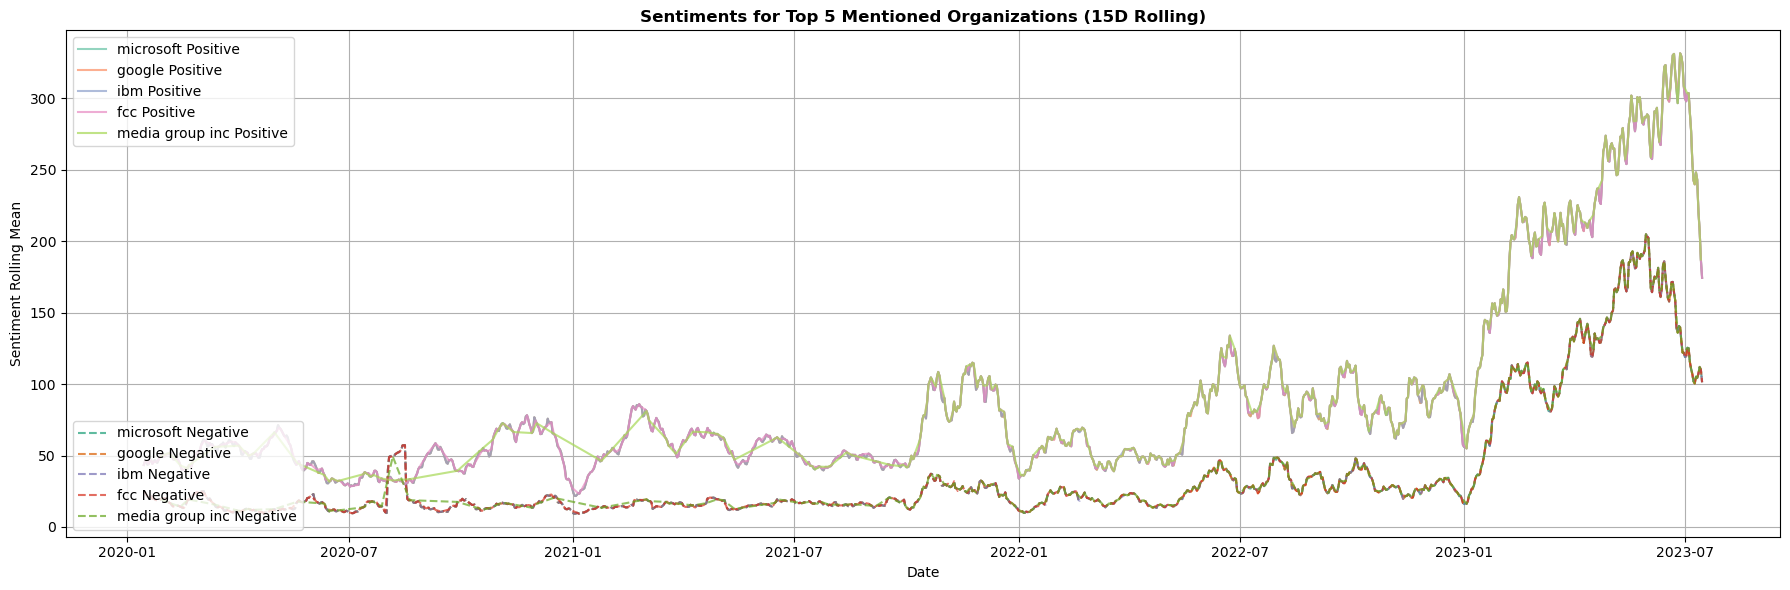

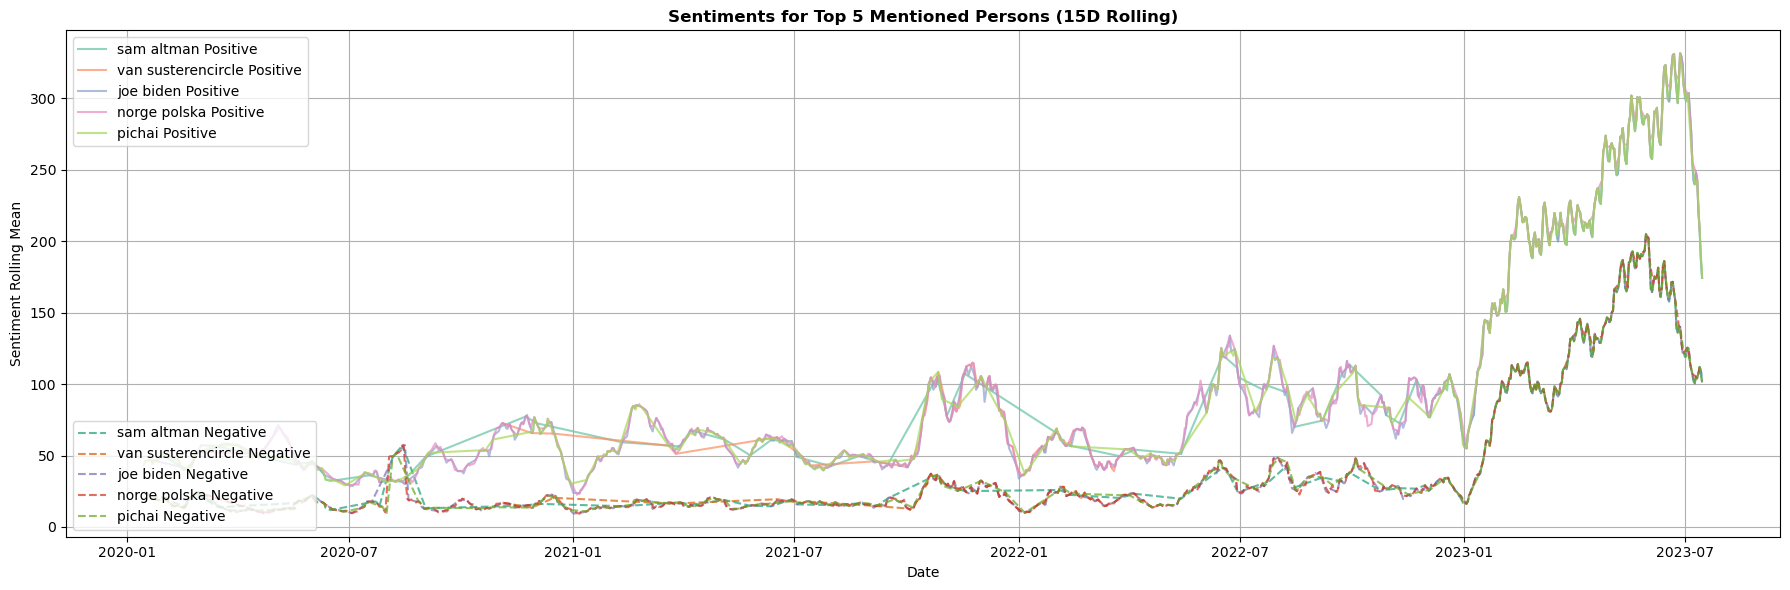

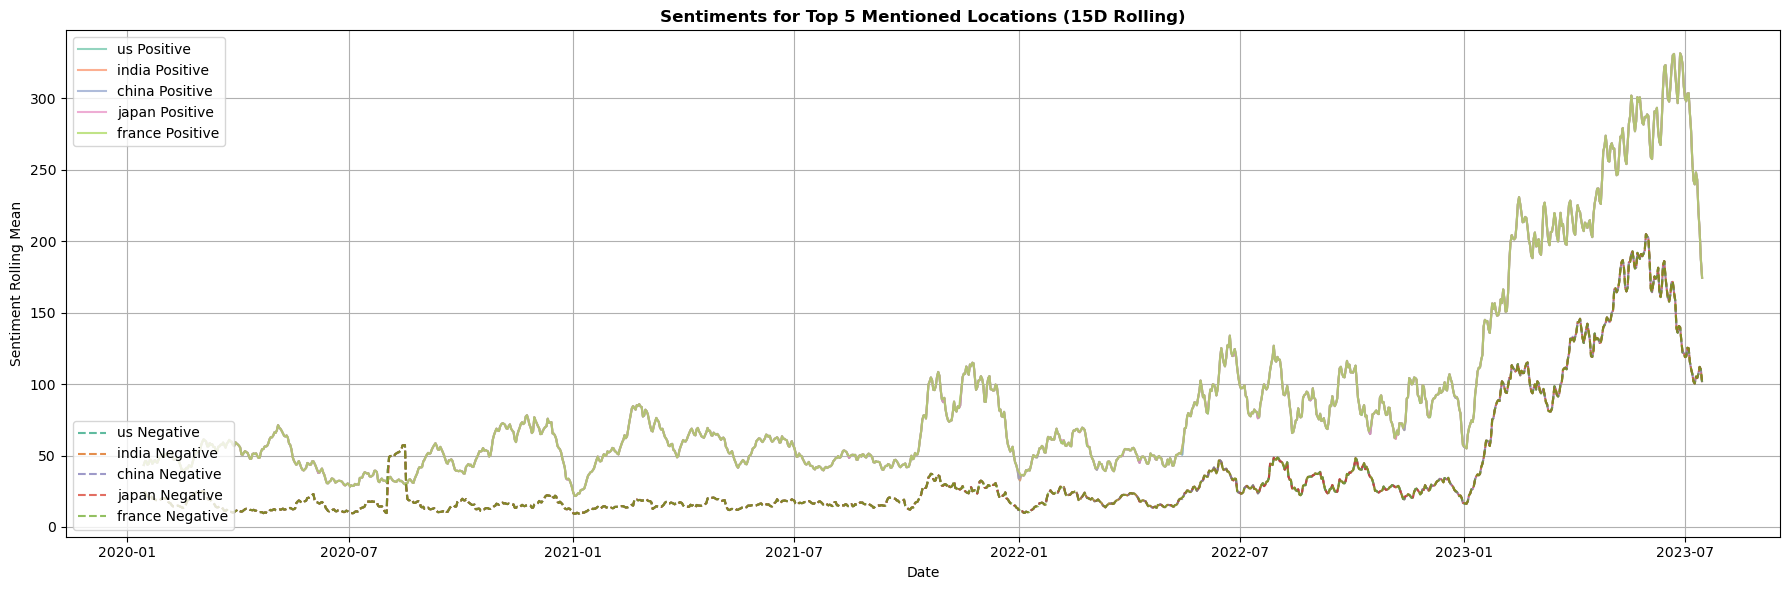

In [26]:
# Plotting sentiments for top 5 organizations, persons, and locations
plot_sentiments_rolling_mean(top_5_orgs, merged_org, "Sentiments for Top 5 Mentioned Organizations (15D Rolling)")
plot_sentiments_rolling_mean(top_5_persons, merged_per, "Sentiments for Top 5 Mentioned Persons (15D Rolling)")
plot_sentiments_rolling_mean(top_5_locs, merged_locs, "Sentiments for Top 5 Mentioned Locations (15D Rolling)")

### Sentiment Analysis - Proportion

In [27]:
def plot_sentiments_proportion(entity_list, merged_sentiments_df, title):
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    
    pos_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']
    neg_colors = ['#1b9e77', '#d95f02', '#7570b3', '#d7301f', '#66a61e']
    positive_legend_handles = []
    negative_legend_handles = []
    
    for idx, entity in enumerate(entity_list):
        entity_df = merged_sentiments_df[merged_sentiments_df['text_clean'].str.contains(entity, case=False, na=False)]
        entity_df = entity_df.sort_values(by='date')
        
        # Calculate sentiment proportions
        entity_df['positive_proportion'] = entity_df['rolling_positive'] / (entity_df['rolling_positive'] + entity_df['rolling_negative'])
        entity_df['negative_proportion'] = entity_df['rolling_negative'] / (entity_df['rolling_positive'] + entity_df['rolling_negative'])
        
        # Plot positive sentiment proportion on the left subplot
        positive_line, = axs[0].plot(entity_df['date'], entity_df['positive_proportion'], color=pos_colors[idx], alpha=0.7, label=f'{entity} Positive')
        positive_legend_handles.append(positive_line)
        
        # Plot negative sentiment proportion on the right subplot
        negative_line, = axs[1].plot(entity_df['date'], entity_df['negative_proportion'], color=neg_colors[idx], alpha=0.7, linestyle='--', label=f'{entity} Negative')
        negative_legend_handles.append(negative_line)
    
    axs[0].set_title(f'Positive Sentiment Trends for {title}', fontweight='bold')
    axs[1].set_title(f'Negative Sentiment Trends for {title}', fontweight='bold')
    axs[1].set_xlabel('Date')
    axs[0].set_ylabel('Sentiment Proportion (0-1)')
    axs[0].grid(True)
    axs[1].grid(True)
    
    # Creating two legends: one for positive trends and one for negative trends
    legend1 = axs[0].legend(handles=positive_legend_handles, loc='upper left')
    legend2 = axs[1].legend(handles=negative_legend_handles, loc='upper left')
    
    plt.tight_layout()
    plt.show()


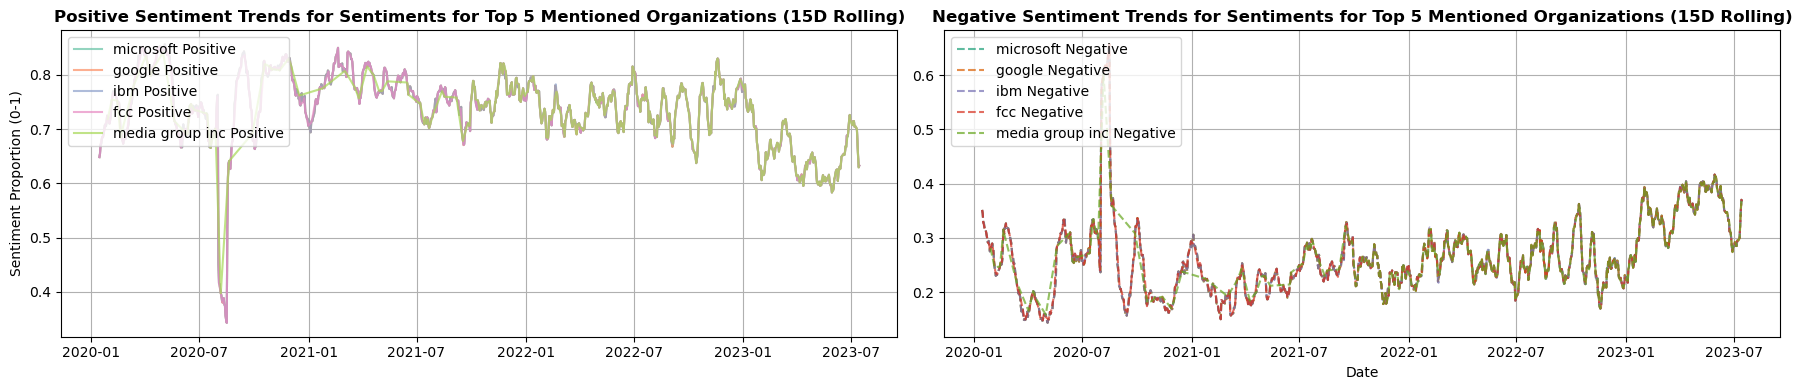

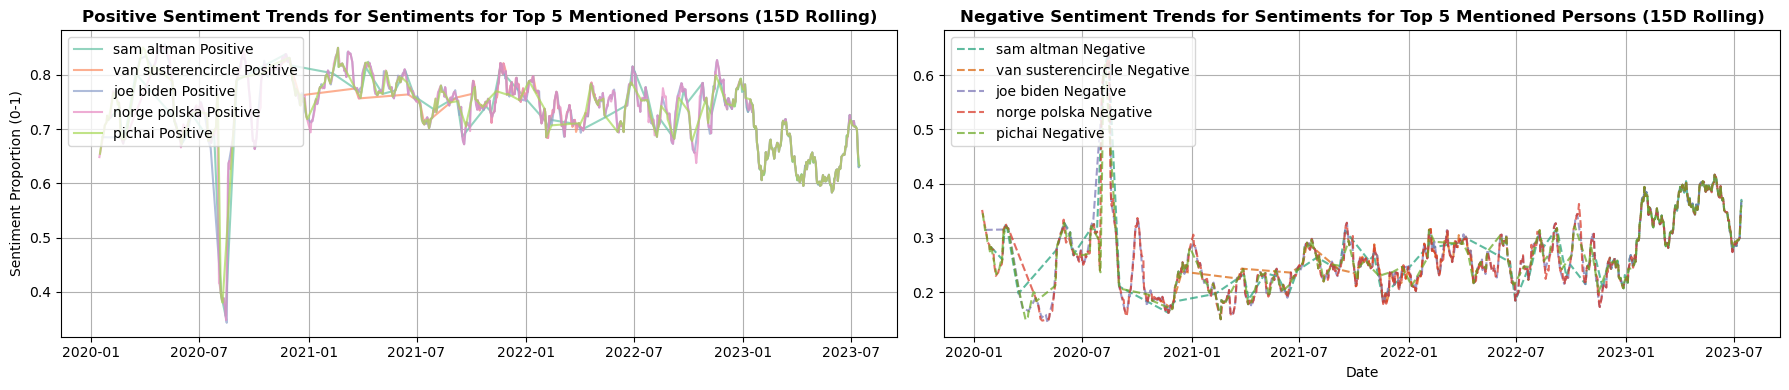

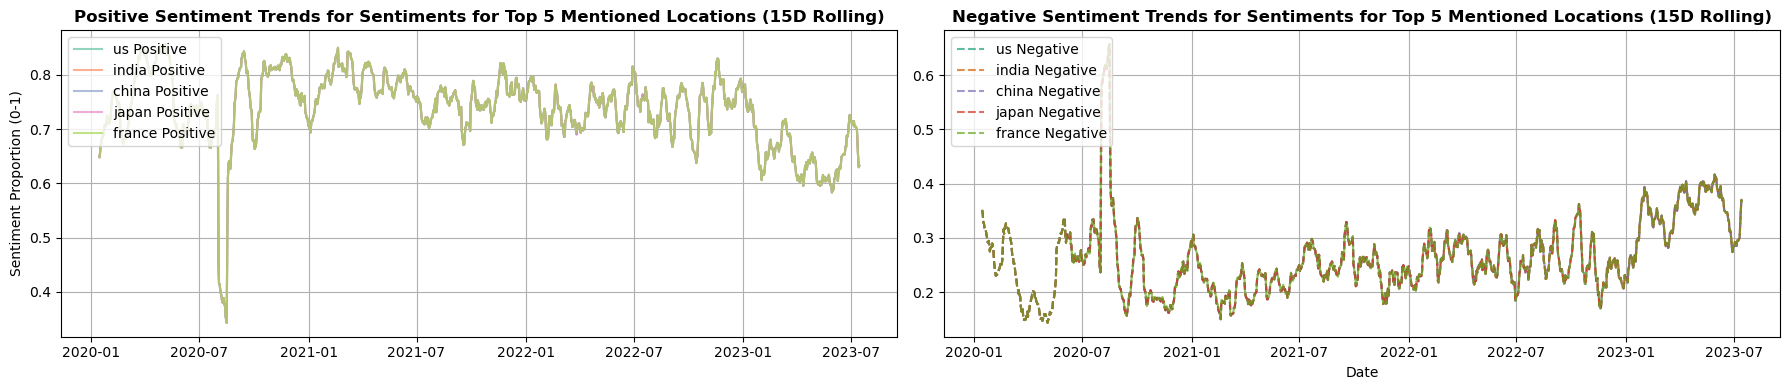

In [28]:
# Plotting sentiments for top 5 organizations, persons, and locations
plot_sentiments_proportion(top_5_orgs, merged_org, "Sentiments for Top 5 Mentioned Organizations (15D Rolling)")
plot_sentiments_proportion(top_5_persons, merged_per, "Sentiments for Top 5 Mentioned Persons (15D Rolling)")
plot_sentiments_proportion(top_5_locs, merged_locs, "Sentiments for Top 5 Mentioned Locations (15D Rolling)")

## Identify Job Impact

### Job Titles Keywords

In [29]:
# Predefined list of common job titles or roles, organized by industry
job_titles_by_industry = {
    'Technology & Development': [
        "engineer", "developer", "cloud architect", "data scientist", "machine learning specialist", 
        "UI/UX designer", "roboticist", "automation specialist", "bioinformatician", 
        "virtual reality developer", "augmented reality developer", "cybersecurity expert"
    ],
    'Medical & Healthcare': [
        "doctor", "nurse", "medical professional", "clinician", "patient care specialist", 
        "healthcare provider", "radiologist", "pathologist", "bioengineer", "genetic counselor", 
        "pharmacist"
    ],

    'Finance & Investment': [
        "financial analyst", "investment banker", "stock broker", 
        "trader", "financial planner", "investor", "banker", "auditor",
        "statistician", "actuary"
    ],

    'Education & Academia': [
        "teacher", "educator", "academic researcher", "research assistant", 
        "student advisor"
    ],

    'Legal & Compliance': [
        "lawyer", "legal professional", "legal assistant", "ethicist",
        "policy analyst"
    ],

    'Business & Management': [
        "manager", "consultant", "business analyst", "product manager", 
        "project coordinator", "supply chain manager", "operations researcher", 
        "HR specialist", "talent acquisition"
    ],

    'Media & Communication': [
        "journalist", "media analyst", "public relations specialist", 
        "content curator", "content creator", "blogger", "vlogger", 
        "podcaster", "streamer", "influencer"
    ],

    'Marketing & Sales': [
        "salesperson", "marketing strategist", "digital marketer", 
        "SEO specialist", "social media manager", "e-commerce specialist"
    ],

    'Design & Architecture': [
        "designer", "architect", "architectural designer", "game designer"
    ],

    'Real Estate & Urban Planning': [
        "real estate broker", "urban planner", "environmental planner", 
        "transport planner"
    ],

    'Security & Forensics': [
        "security analyst", "forensic scientist"
    ],
    'Construction & Infrastructure': [
        "construction worker", "site engineer", "construction manager", "mason", "plumber",
        "electrician", "carpenter", "project estimator", "heavy equipment operator", "surveyor",
        "structural engineer"
    ],
    'Others': [
        "administrator", "therapist", "scientist", "technician", 
        "customer support representative", "event planner", 
        "public health official", "sociologist", "agricultural specialist", 
        "logistics coordinator"
    ]
}

### Extract Tech Keywords

In [30]:
%%time

def get_top_jobs_context(texts, job_titles_by_industry):
    job_mentions = defaultdict(int)
    job_context = defaultdict(list)
    
    for text in tqdm(texts):
        for industry, titles in job_titles_by_industry.items():
            for title in titles:
                if title in text:  # checking the title's presence in the text
                    job_mentions[title] += 1
                    job_context[title].append(text)
                    
    return job_mentions, job_context

# Extract top job mentions and their contexts
job_mentions, job_context = get_top_jobs_context(ai_impact['text_clean'], job_titles_by_industry)

with open(os.path.join(path_ner, 'job_mentions.pkl'), 'wb') as f:
    pickle.dump(job_mentions, f)

100%|██████████| 153834/153834 [01:07<00:00, 2276.20it/s]

CPU times: user 1min 1s, sys: 1.57 s, total: 1min 3s
Wall time: 1min 7s


### Checkpoint

In [31]:
# Read a file from the NER data directory
with open(os.path.join(path_ner, 'job_mentions.pkl'), 'rb') as f:
    job_mentions = pickle.load(f)

sorted_jobs = sorted(job_mentions.items(), key=lambda x: x[1], reverse=True)

In [32]:
# Extract the top 5 jobs
top_5_jobs = [job for job, freq in sorted_jobs[:5]]

# Filter ai_integration based on top jobs in text_clean
job_filtered = ai_impact[ai_impact['text_clean'].str.contains('|'.join(top_5_jobs), case=False, na=False)]

# Merge sentiment data from ai_integration_sentiment based on date
merged_jobs = pd.merge(job_filtered, ai_impact_sentiment, on='date', how='left')

### Top 10 Impacted Jobs

In [33]:
print("Top 10 Jobs in AI Impact on Employment:")
for job, freq in sorted_jobs[:10]:
    print(f"{job}: {freq} mentions")

Top 10 Jobs in AI Impact on Employment:
engineer: 34415 mentions
investor: 31937 mentions
manager: 24172 mentions
scientist: 22713 mentions
developer: 20982 mentions
journalist: 20512 mentions
architect: 13094 mentions
doctor: 9834 mentions
teacher: 9781 mentions
data scientist: 7932 mentions


### Barchart: Top 5 Jobs for AI Impact on Employment

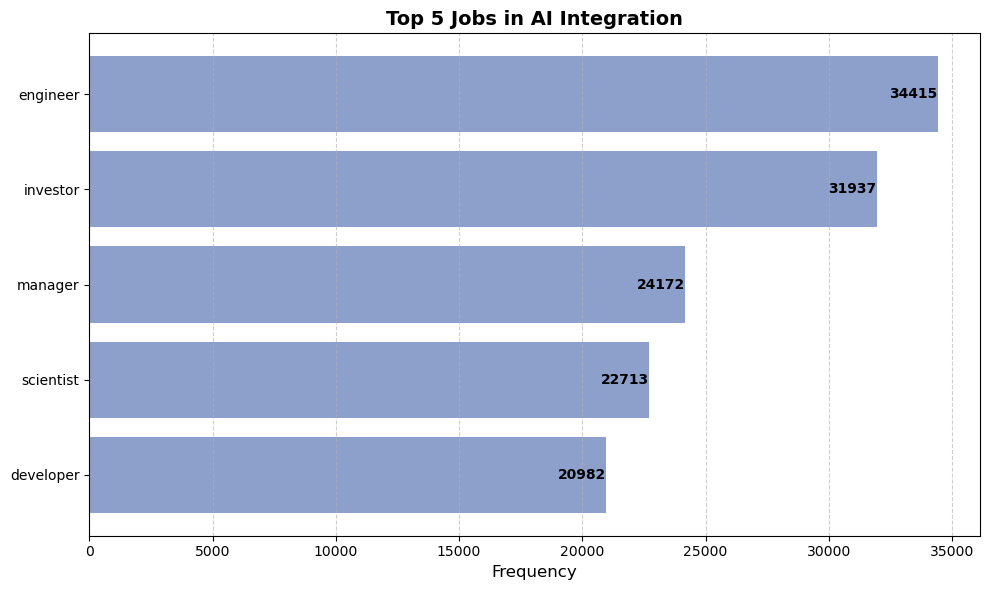

In [34]:
plot_single_entity_chart(sorted_jobs[:5], "Top 5 Jobs in AI Integration", '#8da0cb')

## Visualize the Top Jobs for AI Impact on Employment over Time
Covers:

    - Sentiment Analysis - Rolling Mean
    - Sentiment Analysis - Proportion

### Sentiment Analysis Rolling Mean

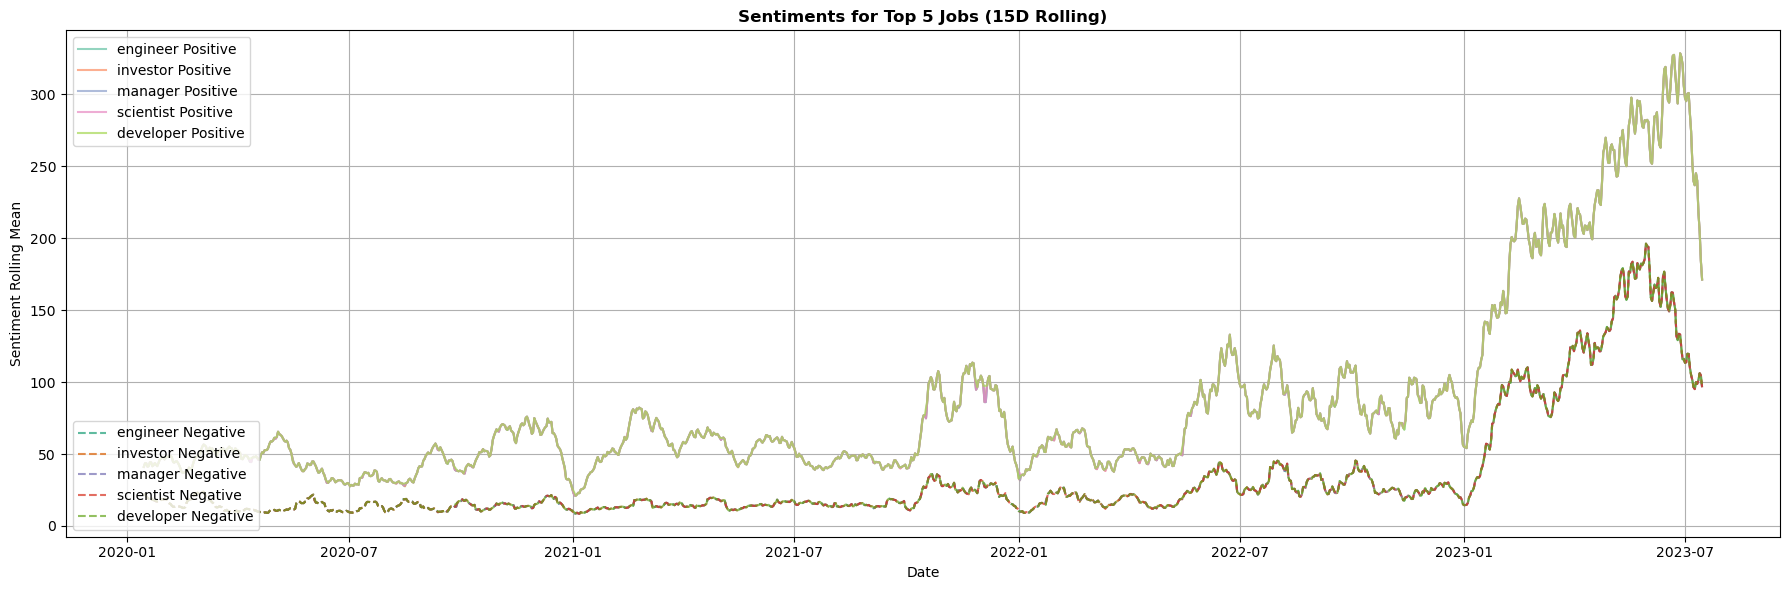

In [35]:
plot_sentiments_rolling_mean(top_5_jobs, merged_jobs, "Sentiments for Top 5 Jobs (15D Rolling)")

### Sentiment Analaysis Proportion
   - a snapshot of the sentiment for a specific time period (e.g., positive sentiments as a proportion of total sentiments on a given day). 
    

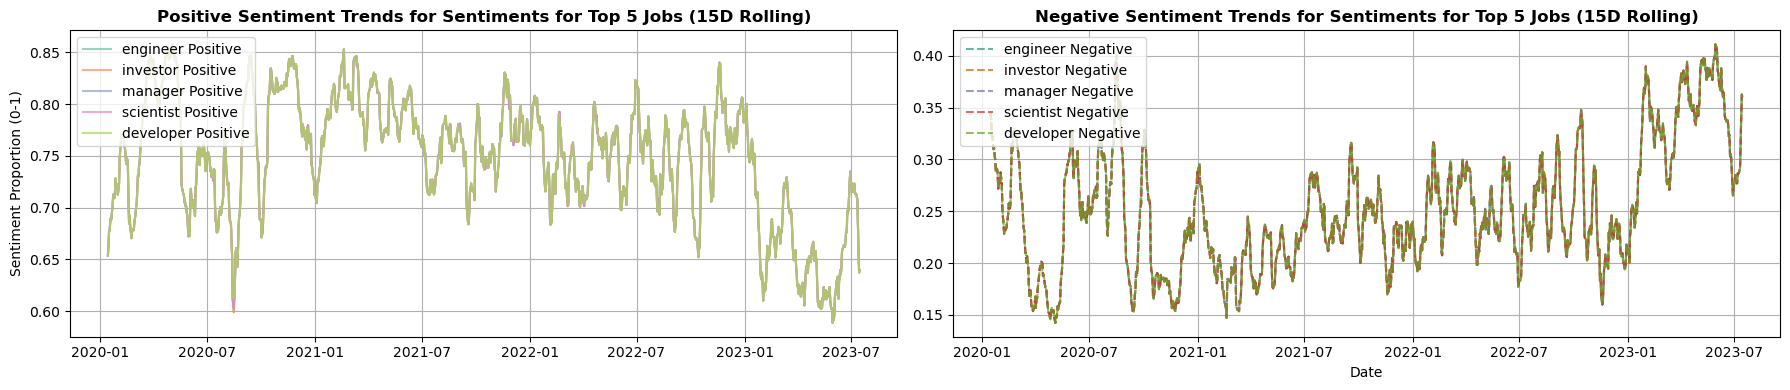

In [36]:
# Plotting sentiments for top 5 jobs
plot_sentiments_proportion(top_5_jobs, merged_jobs, "Sentiments for Top 5 Jobs (15D Rolling)")

## Identify New Technologies & AI Solutions Affecting the Employment Landscape

### New Tech. & AI Solutions Keywords

In [37]:
tech_keywords = [
    'deep learning', 'machine learning', 'neural network', 'convolutional neural network',
    'chatgpt', 'bing', 'data science', 'tensorflow', 'sagemaker', 'watson', 'azure machine learning', 'einstein',
    'reinforcement learning', 'transfer learning', 'augmented reality', 'virtual reality',
    'blockchain', 'quantum computing', 'natural language processing', 'computer vision',
    'edge computing', 'internet of things', '5g', 'robotic process automation', 'rpa', 
    'autonomous vehicle', 'drone', 'wearable tech', 'smart home', 'biometric tech',
    'chatbot', 'voice assistant', 'cryptocurrency', 'serverless computing',
    'augmented analytics', 'ai chips', 'digital twin', 'neuro-linguistic programming', 'predictive analytics',
    'recommendation system', 'fraud detection', 'sentiment analysis', 'image recognition', 
    'speech recognition', 'conversational ai', 'supply chain optimization', 'crm ai', 'ai solution',
    'image generation', 'conversational ai'
]

### Extract Tech Keywords

In [38]:
# %%time

# def get_top_tech_context(texts, tech_keywords):
#     tech_mentions = defaultdict(int)
#     tech_context = defaultdict(list)
    
#     for text in tqdm(texts):
#         for keyword in tech_keywords:
#             if keyword in text:
#                 tech_mentions[keyword] += 1
#                 tech_context[keyword].append(text)
                    
#     return tech_mentions, tech_context

# # Extract top tech mentions and their contexts
# tech_mentions, tech_context = get_top_tech_context(ai_impact['text_clean'], tech_keywords)

# with open(os.path.join(path_ner, 'tech_mentions.pkl'), 'wb') as f:
#     pickle.dump(tech_mentions, f)

### Checkpoint

In [39]:
# Read a file from the NER data directory
with open(os.path.join(path_ner, 'tech_mentions.pkl'), 'rb') as f:
    tech_mentions = pickle.load(f)

# Sort technologies by frequency and get top 10
sorted_tech = sorted(tech_mentions.items(), key=lambda x: x[1], reverse=True)[:10]

### Top 10 New Tech. & AI Solutions

In [40]:
print("Top 10 Technologies in AI Impact on Employment:")
for tech, freq in sorted_tech:
    print(f"{tech}: {freq} mentions")

Top 10 Technologies in AI Impact on Employment:
machine learning: 43503 mentions
chatgpt: 33287 mentions
chatbot: 24391 mentions
bing: 18266 mentions
blockchain: 15625 mentions
deep learning: 13061 mentions
cryptocurrency: 12454 mentions
ai solution: 11698 mentions
rpa: 11573 mentions
data science: 11386 mentions


### Barchart: Top 5 New Tech. & AI Solutions

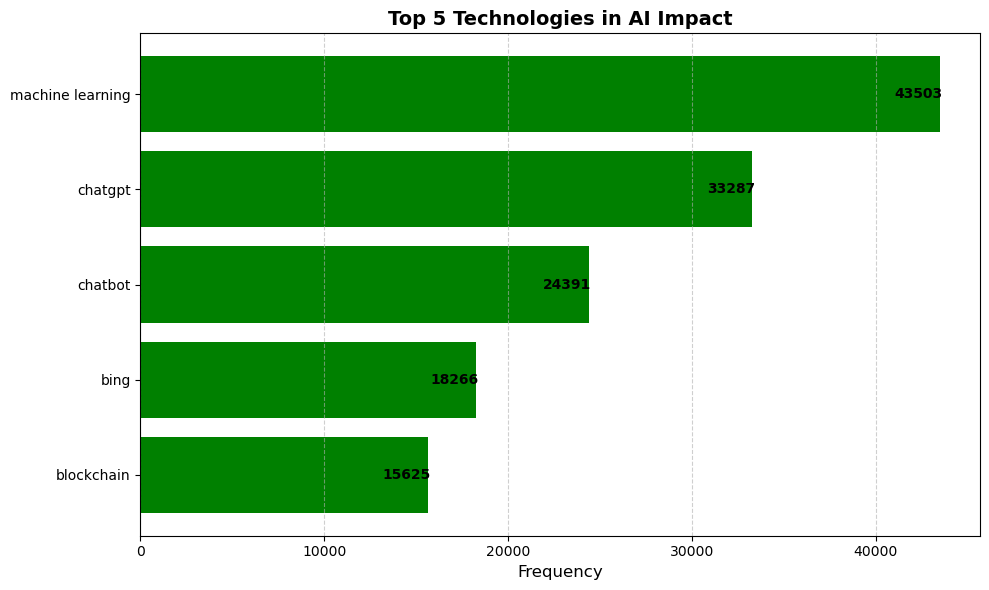

In [41]:
# Plot top 5 new ai
plot_single_entity_chart(sorted_tech[:5], "Top 5 Technologies in AI Impact", 'green')


### Visualize the Timeline of the Top 5 New Tech. & AI Solutions

In [42]:
# Extract the top 5 tech
top_5_tech = [job for job, freq in sorted_tech[:5]]

# Create a regex pattern for strict matching using word boundaries
pattern = r'\b(?:{})\b'.format('|'.join(top_5_tech))

# Filter ai_integration based on top jobs in text_clean with strict matching
tech_filtered = ai_impact[ai_impact['text_clean'].str.contains(pattern, case=False, na=False, regex=True)]

# Merge sentiment data from ai_integration_sentiment based on date
merged_tech = pd.merge(tech_filtered, ai_impact_sentiment, on='date', how='left')


### Plot the timelines to illustrate the introduction of some of these technologies.

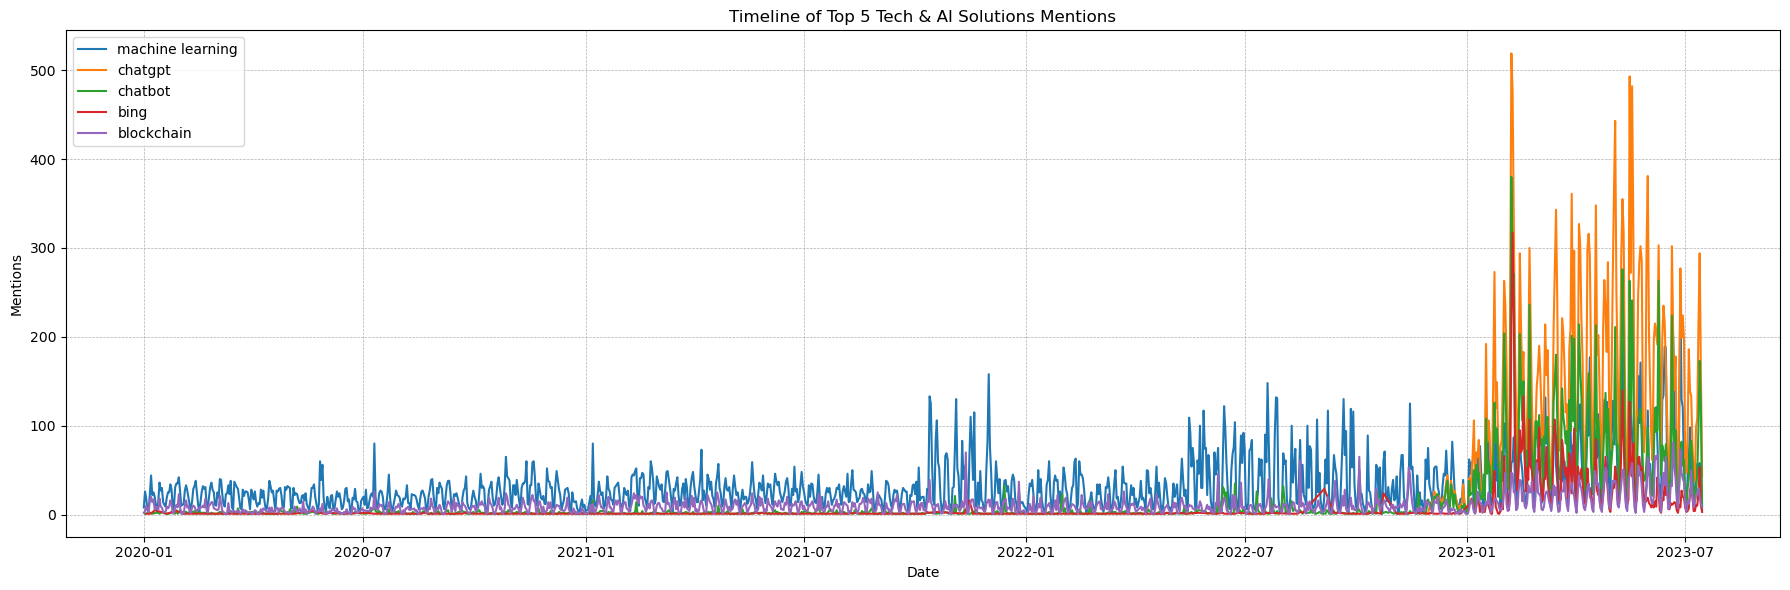

In [43]:
tech_time_series = {}

for tech in top_5_tech:
    tech_pattern = r'\b{}\b'.format(tech)
    tech_df = ai_impact[ai_impact['text_clean'].str.contains(tech_pattern, case=False, na=False, regex=True)]
    aggregated_by_date = tech_df.groupby('date').size()
    tech_time_series[tech] = aggregated_by_date

plt.figure(figsize=(18,6))

# Plot time series for each technology
for tech, timeseries in tech_time_series.items():
    plt.plot(timeseries, label=tech)

plt.title('Timeline of Top 5 Tech & AI Solutions Mentions')
plt.xlabel('Date')
plt.ylabel('Mentions')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### How do people feel about chatgpt and bing and their impact on employment?

In [44]:
selected_techs = ['chatgpt', 'bing']

tech_positive_time_series = {}
tech_negative_time_series = {}

for tech in selected_techs:
    tech_pattern = r'\b{}\b'.format(tech)
    
    # Filtering by tech mentions
    tech_df = merged_tech[merged_tech['text_clean'].str.contains(tech_pattern, case=False, na=False, regex=True)]
    
    # Grouping by date and aggregating the rolling averages
    positive_aggregated_by_date = tech_df.groupby('date')['rolling_positive'].mean()
    negative_aggregated_by_date = tech_df.groupby('date')['rolling_negative'].mean()
    
    tech_positive_time_series[tech] = positive_aggregated_by_date
    tech_negative_time_series[tech] = negative_aggregated_by_date

### Sentiment Analysis - Rolling Mean

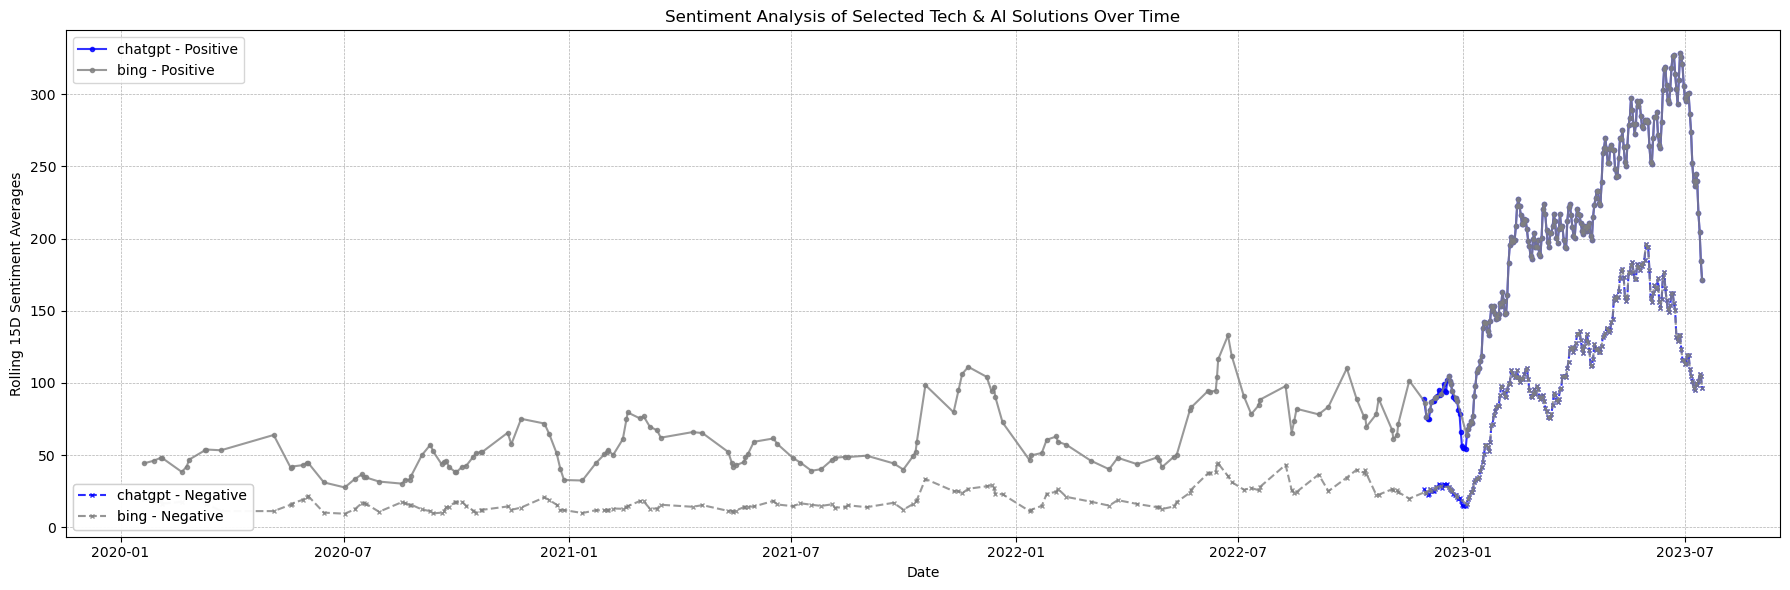

In [45]:
# Define a more viewer-friendly color palette
tech_colors = {
    'chatgpt': 'blue',    
    'bing': 'gray',    
}

plt.figure(figsize=(18,6))

# Plot positive time series for each technology
for tech, positive_series in tech_positive_time_series.items():
    plt.plot(positive_series, label=f"{tech} - Positive", linestyle='-', marker='o', markersize=3, color=tech_colors[tech], alpha=0.8)

# Plot negative time series for each technology
for tech, negative_series in tech_negative_time_series.items():
    plt.plot(negative_series, label=f"{tech} - Negative", linestyle='--', marker='x', markersize=3, color=tech_colors[tech], alpha=0.8)

# Handle legends: Separate positive and negative legends
handles, labels = plt.gca().get_legend_handles_labels()
positive_handles = handles[:len(selected_techs)]
negative_handles = handles[len(selected_techs):]

# Place positive legend at upper left and negative legend at lower left
plt.gca().add_artist(plt.legend(handles=positive_handles, loc='upper left'))
plt.gca().add_artist(plt.legend(handles=negative_handles, loc='lower left'))

plt.title('Sentiment Analysis of Selected Tech & AI Solutions Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling 15D Sentiment Averages')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## The Types of Companies, Planning to Invest in Tech Today or Near Future Based on NER AI Integration
    - Success Stories

### Checkpoint

In [46]:
pkl_file_path = os.path.join(path_ner, 'merged_suc_org.pkl')
merged_org = pd.read_pickle(pkl_file_path)

### Apply Positive-Dominant Target Sentiment Analysis on Loaded NER 

In [47]:
# Filter out records with positive sentiment:
positive_suc_org = merged_org[merged_org['positive_proportion'] > merged_org['negative_proportion']]
print(f"Number of records with positive sentiments: {len(positive_suc_org)}")


Number of records with positive sentiments: 158681


### Define Relevant Successful Keywords

In [48]:
# Define relevant keywords
keywords = ["investment", "funding", "research", "development", "success", "growth", "innovation", "strategy", "initiatives", "partnerships", "acquisitions"]

### Extract Successful Companies from the result of NER 

In [49]:
# Gather companies based on investment mentions from positive records
sorted_orgs = sorted(integration_org_entities.items(), key=lambda x: x[1], reverse=True)

# Convert positive_suc_org['text_clean'] to a set for faster lookup
positive_texts_set = set(positive_suc_org['text_clean'].tolist())

orgs_investment_positive = {}
for org, freq in tqdm(sorted_orgs, desc="Processing organizations"):
    org_context = integration_org_context[org]
    mentions = [sent for sent in org_context if sent in positive_texts_set]
    orgs_investment_positive[org] = sum(1 for sent in mentions if any(keyword in sent for keyword in keywords))


Processing organizations: 100%|██████████| 209497/209497 [00:38<00:00, 5445.25it/s] 


### Top 5 Organizations Planning to Invest in AI

In [50]:
# Get the top 10 organizations based on positive mentions related to investments
top_5_positive_orgs = sorted(orgs_investment_positive.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Organizations Based on Positive Mentions:")
for org, freq in top_5_positive_orgs:
    print(f"{org}: {freq} mentions")

Top 5 Organizations Based on Positive Mentions:
microsoft: 7591 mentions
fcc: 6160 mentions
google: 5766 mentions
ibm: 4793 mentions
gpt: 2690 mentions


In [51]:
# Extract the top 5 organizations, persons, and locations
top_5_orgs = [org for org, freq in top_5_positive_orgs]

# Filter ai_integration based on top organizations in text
org_filtered = ai_integration[ai_integration['text_clean'].str.contains('|'.join(top_5_orgs), case=False, na=False)]

# Merge sentiment data from ai_integration_sentiment based on date
merged_org = pd.merge(org_filtered, ai_integration_sentiment, on='date', how='left')

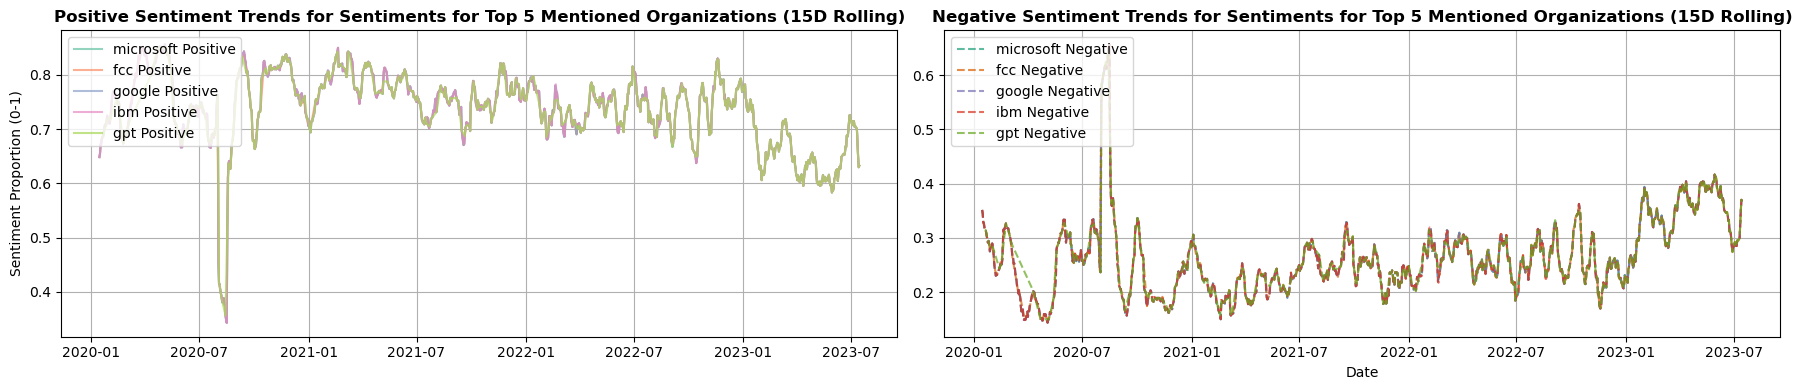

In [52]:
plot_sentiments_proportion(top_5_orgs, merged_org, "Sentiments for Top 5 Mentioned Organizations (15D Rolling)")


### Visualize Word Cloud Chart for the Successful Organizations

In [53]:
# List of countries to explicitly remove
country_list = ["czech denmark finland"]

# Remove entries from orgs_investment_positive that are also in integration_loc_entities
filtered_orgs_investment_positive = {org: freq for org, freq in orgs_investment_positive.items() if org not in integration_loc_entities and org not in country_list}

# Define a function to process organization names
def process_org_name(org_name):
    # Map of long names to their abbreviations
    abbreviations = {
        "media group inc station gray television inc": "gray television"
    }
    
    # If the org_name matches any key in abbreviations, return the corresponding abbreviation
    if org_name in abbreviations:
        return abbreviations[org_name]
    
    # If the name is longer than a threshold, return None to exclude it
    if len(org_name) > 25:  # You can adjust the threshold
        return None
    
    return org_name

In [54]:
# Apply the process_org_name function
filtered_orgs_investment_positive_processed = {process_org_name(org): freq for org, freq in filtered_orgs_investment_positive.items() if process_org_name(org)}

/Users/hyojun/anaconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


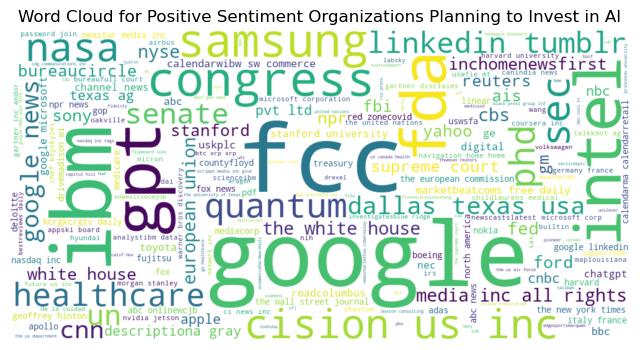

In [55]:
# Generate the word cloud using the processed dictionary with a max font size
wc = WordCloud(width=1000, height=500, background_color="white", colormap="viridis", max_font_size=150)
wordcloud = wc.generate_from_frequencies(filtered_orgs_investment_positive_processed)

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment Organizations Planning to Invest in AI")
plt.show()

### Log-Scaled Word Cloud Chart for the Successful Organizations

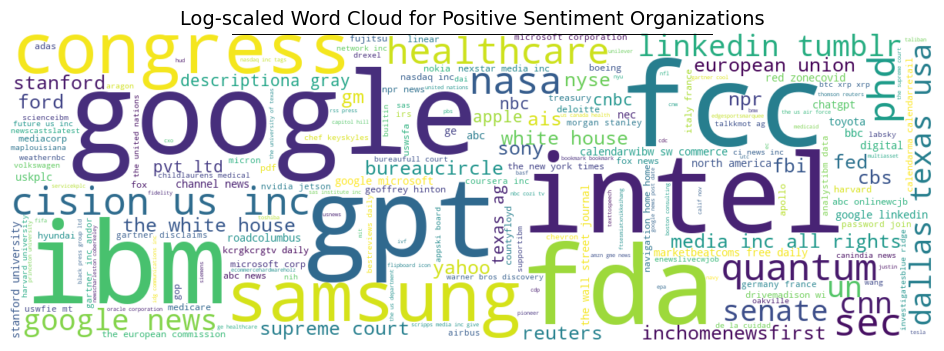

In [56]:
# Log scaling of frequencies
filtered_orgs_investment_positive_processed = {org: np.log1p(freq) for org, freq in filtered_orgs_investment_positive_processed.items()}

# Generate the word cloud using the processed dictionary with a max font size
wc = WordCloud(width=1200, height=400, background_color="white", colormap="viridis", max_font_size=150)
wordcloud = wc.generate_from_frequencies(filtered_orgs_investment_positive_processed)

# Display the word cloud
fig, ax = plt.subplots(figsize=(13,4))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis('off')

title = "Log-scaled Word Cloud for Positive Sentiment Organizations"
ax.set_title(title, fontsize=14)

# Creating underline for title
# The two numbers in 'ax.axhline()' are the Y position and the length of the underline respectively
ax.axhline(y=1.05, xmin=0.24, xmax=0.76, color='black', linewidth=0.7)

plt.show()


## The Types of Applications cannot Currently be Transformed by AI - Failures

### Extract Only Negative Sentiment

In [57]:
# Sort technologies by frequency and get top 10
sorted_tech = sorted(tech_mentions.items(), key=lambda x: x[1], reverse=True)

# Extract only the technology names from the sorted list
sorted_tech_names = [item[0] for item in sorted_tech]

# Create a regex pattern for strict matching using word boundaries
pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, sorted_tech_names)))  # added re.escape to handle multiple words

# Filter ai_integration based on top jobs in text_clean with strict matching
tech_filtered = ai_integration[ai_integration['text_clean'].str.contains(pattern, case=False, na=False, regex=True)]

# Merge sentiment data from ai_integration_sentiment based on date
merged_tech = pd.merge(tech_filtered, ai_integration_sentiment, on='date', how='left')

### Filter Negative Yelp Sentiment to find Coordinated Applications

In [58]:
# Filter out records where the records are the negative sentiment
negative_tech = merged_tech[merged_tech['blended_sentiment'] == 'negative']
print(f"Number of records with negative sentiments: {len(negative_tech)}")

Number of records with negative sentiments: 28957


In [59]:
negative_keywords = ["failure", "problem", "issue", "cant", "cannot", "struggle", "limitation", "setback", "drawback", "flaw", "bug"]

### Top 10 Negative Applications

In [60]:
def find_negative_mentions(text):
    mentions = {}
    for tech in sorted_tech_names:
        # Only count if one of the negative keywords is also in the text
        if any(neg_kw in text for neg_kw in negative_keywords):
            mentions[tech] = text.count(tech)
    return mentions

# Using tqdm for progress bar
negative_mentions_list = list(tqdm(negative_tech['text_clean'].parallel_apply(find_negative_mentions)))

100%|██████████| 28957/28957 [00:00<00:00, 6817921.91it/s]


In [61]:
negative_app_mentions = Counter()
for mention in negative_mentions_list:
    negative_app_mentions.update(mention)
    
# Calculate total mentions
total_mentions = {tech: sum(merged_tech['text_clean'].str.contains(r'\b{}\b'.format(re.escape(tech)), case=False)) for tech in sorted_tech_names}

# Compute negative proportion
negative_proportions = {tech: negative_app_mentions[tech] / total_mentions[tech] for tech in sorted_tech_names if total_mentions[tech] > 0}

# Rank by negative proportion
sorted_by_negative_proportion = sorted(negative_proportions.items(), key=lambda x: x[1], reverse=True)

# Displaying the top 10 technologies with the highest negative proportions
print(sorted_by_negative_proportion[:10])  

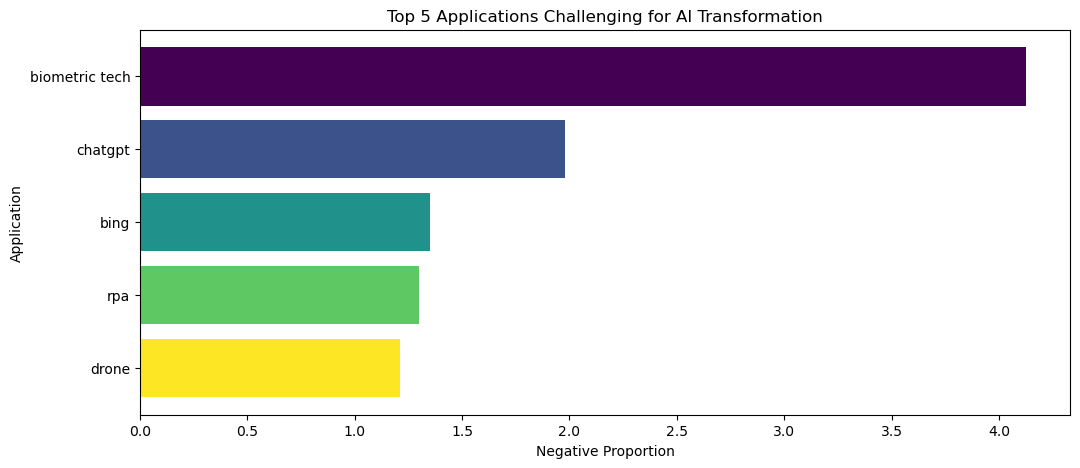

In [ ]:
# Extract the top 10 applications and their negative proportions
top_10_negative_apps = sorted_by_negative_proportion[:5]
apps = [item[0] for item in top_10_negative_apps]
proportions = [item[1] for item in top_10_negative_apps]

# Use a colormap
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(apps))]

# Plot the bar chart
plt.figure(figsize=(12, 5))
bars = plt.barh(apps, proportions, color=colors)

# Invert the y-axis to display the highest proportion at the top
plt.gca().invert_yaxis()

# Labelling and displaying the plot
plt.xlabel('Negative Proportion')
plt.ylabel('Application')
plt.title('Top 5 Applications Challenging for AI Transformation')
plt.show()

### Top 5 Negative Applications

In [ ]:
# Calculate total mentions
total_mentions = {tech: sum(merged_tech['text_clean'].str.contains(r'\b{}\b'.format(re.escape(tech)), case=False)) for tech in sorted_tech_names}

# Compute negative proportion
negative_proportions = {tech: negative_app_mentions[tech] / total_mentions[tech] for tech in sorted_tech_names if total_mentions[tech] > 0}

# Rank by negative proportion
sorted_by_negative_proportion = sorted(negative_proportions.items(), key=lambda x: x[1], reverse=True)

# Displaying the top 5 technologies with the highest negative proportions
print(sorted_by_negative_proportion[:5])  


[('biometric tech', 4.125), ('chatgpt', 1.97859392031004), ('bing', 1.35181805419065), ('rpa', 1.3), ('drone', 1.209205020920502)]


### Visualize Word Cloud Chart for Negative Applications

/Users/hyojun/anaconda3/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


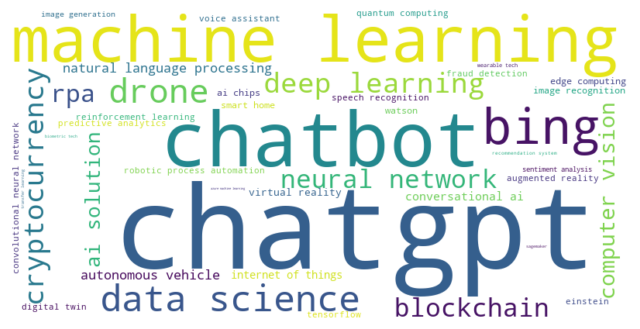

In [ ]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_app_mentions)

# Display the generated image:
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Bubble Chart

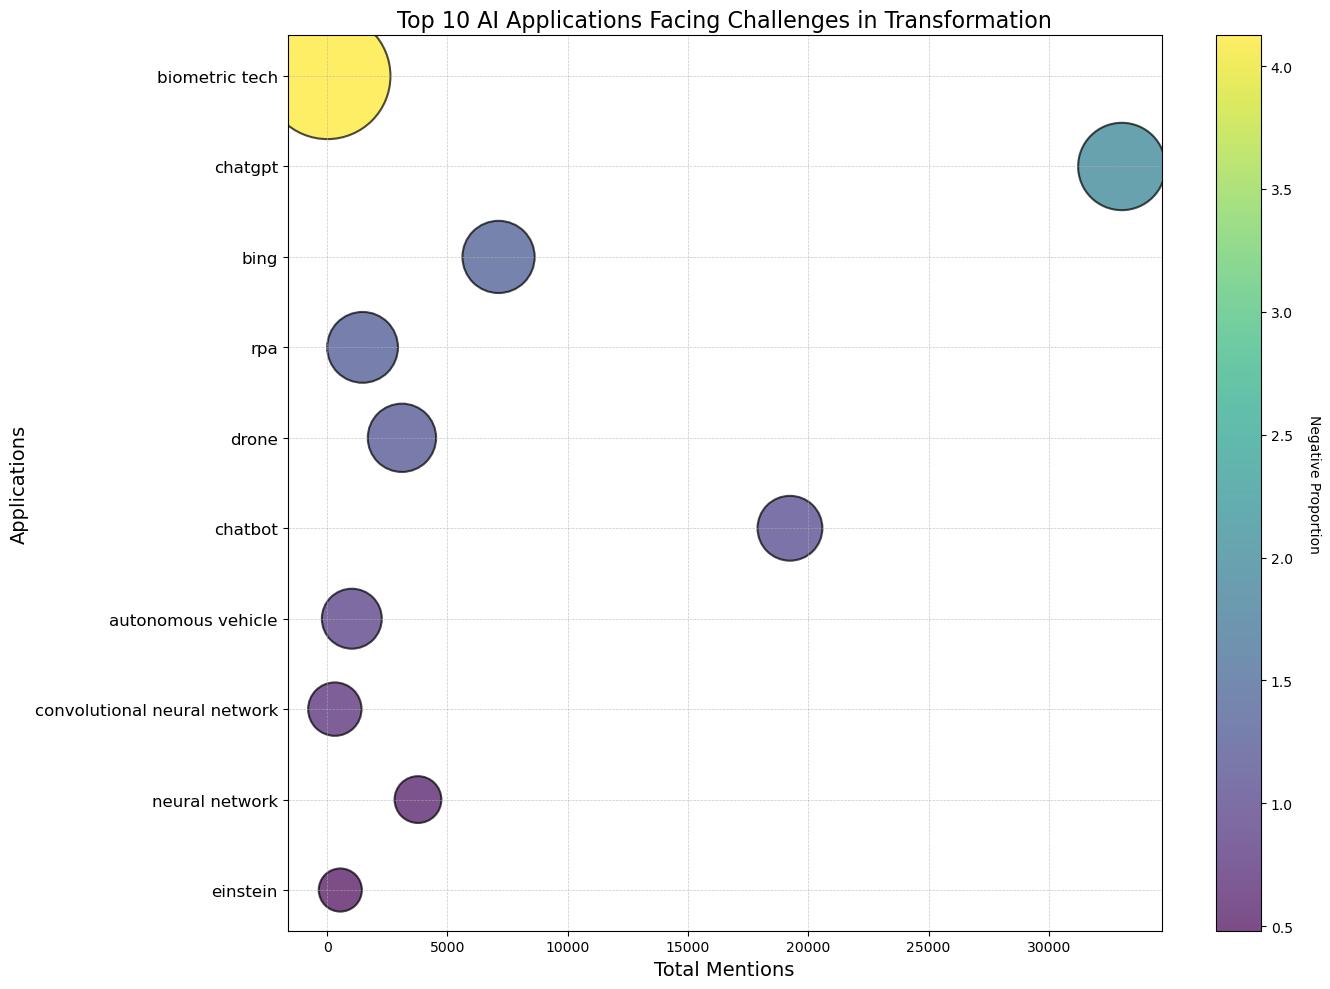

In [ ]:
# Get data for only the top 10 applications
top_10 = sorted_by_negative_proportion[:10]
apps = [item[0] for item in top_10]
proportions = [item[1] for item in top_10]
total_mentions_list = [total_mentions[app] for app in apps]

# Adjust bubble sizes.
bubble_sizes = [prop * 2000 for prop in proportions]

# Create a colormap for bubble colors
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0.5, 1, len(apps))]

# Plot
plt.figure(figsize=(14, 10))
scatter = plt.scatter(total_mentions_list, range(len(apps)), s=bubble_sizes, c=proportions, cmap='viridis', edgecolors='black', linewidths=1.5, alpha=0.7)

# Create a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Negative Proportion', rotation=270, labelpad=20)

# Labelling and displaying the plot
plt.yticks(range(len(apps)), apps, fontsize=12)
plt.xlabel('Total Mentions', fontsize=14)
plt.ylabel('Applications', fontsize=14)
plt.title('Top 10 AI Applications Facing Challenges in Transformation', fontsize=16)
plt.gca().invert_yaxis()  # Display the application with the highest total mentions at the top
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


<div class="AI Integration & Acceleration: A Collaborative Roadmap">
    <h2>Actionable Recommendations:</h2>
    
<div class="recommendation">
    <h3>1. Build Synergies with Prominent AI Players and Esteemed Influencers:</h3>
    <p><strong>Background:</strong> Giants in the AI realm, such as Microsoft, Google, and IBM, are continually setting industry benchmarks. When coupled with the endorsements of AI leaders like Sam Altman and Joe Biden, the impact is monumental.</p>
    <p><strong>Recommendation:</strong> Engage in collaborative ventures with these leaders or invite them for talks or sessions. Such associations can reinforce their commitment to AI and fortify the brand's position.</p>
</div>

<div class="recommendation">
    <h3>2. Equip Tomorrow's Workforce with AI Skillsets:</h3>
    <p><strong>Background:</strong> There's a notable surge in demand for roles such as engineers and investors, complemented by the rise of transformative tools like machine learning and ChatGPT.</p>
    <p><strong>Recommendation:</strong> Roll out advanced educational modules geared towards these specific roles, ensuring the next generation is prepared to harness the AI revolution effectively.</p>
</div>

<div class="recommendation">
    <h3>3. Prioritize Ethical AI and Address Potential Pitfalls:</h3>
    <p><strong>Background:</strong> Some AI innovations, like biometric technology and ChatGPT, have received mixed responses, underscoring potential challenges such as providing incorrect information.</p>
    <p><strong>Recommendation:</strong> Commit to a research-backed approach to assess and rectify these concerns, ensuring AI practices remain both ethical and transparent. uch commitment can boost trustworthiness and cultivate a reliable relationship with stakeholders.</p>
</div>

<div class="recommendation">
    <h3>4. Strengthen Presence in AI Innovation Hubs:</h3>
    <p><strong>Background:</strong> Regions, such as the US, India, and China, are burgeoning with AI activities and discourse.</p>
    <p><strong>Recommendation:</strong> Enhance visibility in these key locales through region-specific initiatives, partnerships, or by establishing dedicated AI hubs. Capitalizing on this concentrated AI enthusiasm can propel the brand's reach and influence.</p>
</div>
